# Keras + Albumentations: Cats vs Dogs Classification

Complete training pipeline with automatic device detection (CUDA/MPS/CPU).

In [ ]:
# %pip install -q tensorflow keras tensorflow-datasets
# %pip install -q albumentationsx
# %pip install -q opencv-python-headless matplotlib

In [ ]:
import platform
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

# Display plots inline in the notebook
%matplotlib inline

import tensorflow as tf
import tensorflow_datasets as tfds
import keras
from keras import layers, models, optimizers, metrics, callbacks
import albumentations as A

print(f"TensorFlow: {tf.__version__}")
print(f"Keras: {keras.__version__}")
print(f"Albumentations: {A.__version__}")

TensorFlow: 2.19.1
Keras: 3.11.3
Albumentations: 2.0.11


In [ ]:
def detect_device() -> Tuple[str, int]:
    cuda_gpus = tf.config.list_physical_devices("GPU")
    if cuda_gpus:
        print(f"✓ CUDA GPU detected: {len(cuda_gpus)} device(s)")
        for gpu in cuda_gpus:
            try:
                tf.config.experimental.set_memory_growth(gpu, True)
            except:
                pass
        return "CUDA_GPU", 64
    if platform.system() == "Darwin" and platform.machine() == "arm64":
        print("✓ Apple Silicon MPS detected")
        return "MPS", 32
    print("✓ CPU detected")
    return "CPU", 16

DEVICE, BATCH_SIZE = detect_device()
print(f"→ Using {DEVICE} with batch size {BATCH_SIZE}")

✓ Apple Silicon MPS detected
→ Using MPS with batch size 32


In [ ]:
class Config:
    input_shape = (128, 128, 3)
    num_classes = 1
    batch_size = BATCH_SIZE
    epochs = 10
    learning_rate = 1e-3
    train_split = "train[:70%]"
    val_split = "train[70%:90%]"
    test_split = "train[90%:]"
    model_path = f"cats_dogs_{DEVICE.lower()}.keras"

config = Config()
print(f"Batch size: {config.batch_size}, Epochs: {config.epochs}")

Batch size: 32, Epochs: 10


## Data Augmentation - Using Exact Parameters from Working Script

In [ ]:
def create_augmentation_pipeline(is_training: bool = True) -> A.Compose:
    if is_training:
        return A.Compose([
            A.RandomResizedCrop(size=(128, 128), scale=(0.8, 1.0)),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.3),
            A.OneOf([
                A.GaussNoise(std_range=(0.1, 0.2), p=1),
                A.GaussianBlur(blur_limit=(3, 5), p=1),
            ], p=0.2),
            A.CoarseDropout(num_holes_range=(1, 8), hole_height_range=(0.0625, 0.125), hole_width_range=(0.0625, 0.125), p=0.3),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    else:
        return A.Compose([
            A.Resize(height=128, width=128),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

train_transform = create_augmentation_pipeline(True)
val_transform = create_augmentation_pipeline(False)
print("✓ Augmentation pipelines created")

✓ Augmentation pipelines created


## Load and Prepare Dataset


In [ ]:
# Load dataset
print("Downloading Cats vs Dogs dataset...")
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=[config.train_split, config.val_split, config.test_split],
    with_info=True,
    as_supervised=True,
    shuffle_files=True
)
print(f"✓ Dataset loaded: {ds_info.splits['train'].num_examples} examples")

# Apply augmentations
def augment_image(image, label, transform):
    def apply(img):
        augmented = transform(image=img.numpy())
        return augmented['image'].astype(np.float32)
    
    aug_img = tf.py_function(apply, [image], tf.float32)
    aug_img.set_shape([128, 128, 3])
    return aug_img, label

# Prepare datasets
train_dataset = ds_train.map(
    lambda x, y: augment_image(x, y, train_transform),
    num_parallel_calls=tf.data.AUTOTUNE
).cache().shuffle(1000).batch(config.batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = ds_val.map(
    lambda x, y: augment_image(x, y, val_transform),
    num_parallel_calls=tf.data.AUTOTUNE
).cache().batch(config.batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = ds_test.map(
    lambda x, y: augment_image(x, y, val_transform),
    num_parallel_calls=tf.data.AUTOTUNE
).cache().batch(config.batch_size).prefetch(tf.data.AUTOTUNE)

print("✓ Data pipeline ready")


✓ Dataset loaded: 23262 examples
✓ Data pipeline ready


## Build and Train Model


In [ ]:
# Create model
model = models.Sequential([
    layers.Input(shape=config.input_shape),
    
    # Block 1
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),
    layers.Dropout(0.25),
    
    # Block 2
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),
    layers.Dropout(0.25),
    
    # Block 3
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),
    layers.Dropout(0.25),
    
    # Block 4
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    
    # Dense layers
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    # Output
    layers.Dense(config.num_classes, activation='sigmoid')
])

# Compile
model.compile(
    optimizer=optimizers.Adam(learning_rate=config.learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy', metrics.AUC(name='auc')]
)

print(f"✓ Model created with {model.count_params():,} parameters")
model.summary()


✓ Model created with 490,689 parameters


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 490,689 (1.87 MB)

 Trainable params: 488,961 (1.87 MB)

 Non-trainable params: 1,728 (6.75 KB)

In [ ]:
# Train with callbacks
callbacks_list = [
    callbacks.ModelCheckpoint(
        'best_model.keras',
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

print(f"Training on {DEVICE} for {config.epochs} epochs...")

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=config.epochs,
    callbacks=callbacks_list,
    verbose=1
)

print("✓ Training completed!")


Training on MPS for 10 epochs...
Epoch 1/10


2025-09-17 18:53:16.505703: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


509/509 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.5301 - auc: 0.5423 - loss: 0.8683
Epoch 1: val_auc improved from None to 0.63414, saving model to best_model.keras
509/509 ━━━━━━━━━━━━━━━━━━━━ 68s 131ms/step - accuracy: 0.5438 - auc: 0.5613 - loss: 0.7959 - val_accuracy: 0.5682 - val_auc: 0.6341 - val_loss: 0.6740 - learning_rate: 0.0010
Epoch 2/10
509/509 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.5700 - auc: 0.5999 - loss: 0.6970
Epoch 2: val_auc improved from 0.63414 to 0.73070, saving model to best_model.keras
509/509 ━━━━━━━━━━━━━━━━━━━━ 65s 127ms/step - accuracy: 0.5885 - auc: 0.6244 - loss: 0.6781 - val_accuracy: 0.6682 - val_auc: 0.7307 - val_loss: 0.6142 - learning_rate: 0.0010
Epoch 3/10
509/509 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.6304 - auc: 0.6839 - loss: 0.6387
Epoch 3: val_auc did not improve from 0.73070
509/509 ━━━━━━━━━━━━━━━━━━━━ 69s 135ms/step - accuracy: 0.6461 - auc: 0.7005 - loss: 0.6275 - val_accuracy: 0.6336 - val_auc: 0.7236 - val_los

## Evaluate and Save Model


In [ ]:
# Evaluate on test set
test_results = model.evaluate(test_dataset, verbose=1, return_dict=True)

print("\n✓ Test Results:")
for metric, value in test_results.items():
    print(f"  {metric}: {value:.4f}")

# Save model
model.save(config.model_path)
print(f"\n✓ Model saved as {config.model_path}")

# Convert to TFLite
try:
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model = converter.convert()
    
    tflite_path = config.model_path.replace('.keras', '.tflite')
    with open(tflite_path, 'wb') as f:
        f.write(tflite_model)
    print(f"✓ TFLite model saved as {tflite_path} ({len(tflite_model)/1024:.2f} KB)")
except Exception as e:
    print(f"TFLite conversion failed: {e}")


73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8547 - auc: 0.9369 - loss: 0.3232

✓ Test Results:
  accuracy: 0.8547
  auc: 0.9369
  loss: 0.3232

✓ Model saved as cats_dogs_mps.keras
INFO:tensorflow:Assets written to: /var/folders/68/k137nch11m76w1plfrw320r00000gn/T/tmp0otru8h6/assets


INFO:tensorflow:Assets written to: /var/folders/68/k137nch11m76w1plfrw320r00000gn/T/tmp0otru8h6/assets


Saved artifact at '/var/folders/68/k137nch11m76w1plfrw320r00000gn/T/tmp0otru8h6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  4705823808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5583028288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5583034096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5583043776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5583030224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5583033744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5583037440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5583034448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5583040256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5583038848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5583029168: TensorSp

W0000 00:00:1758128695.974261 105836395 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1758128695.974270 105836395 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-09-17 19:04:55.974428: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/68/k137nch11m76w1plfrw320r00000gn/T/tmp0otru8h6
2025-09-17 19:04:55.975394: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-09-17 19:04:55.975398: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/68/k137nch11m76w1plfrw320r00000gn/T/tmp0otru8h6
I0000 00:00:1758128695.983613 105836395 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
2025-09-17 19:04:55.985110: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-09-17 19:04:56.043013: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/

## Visualize Results


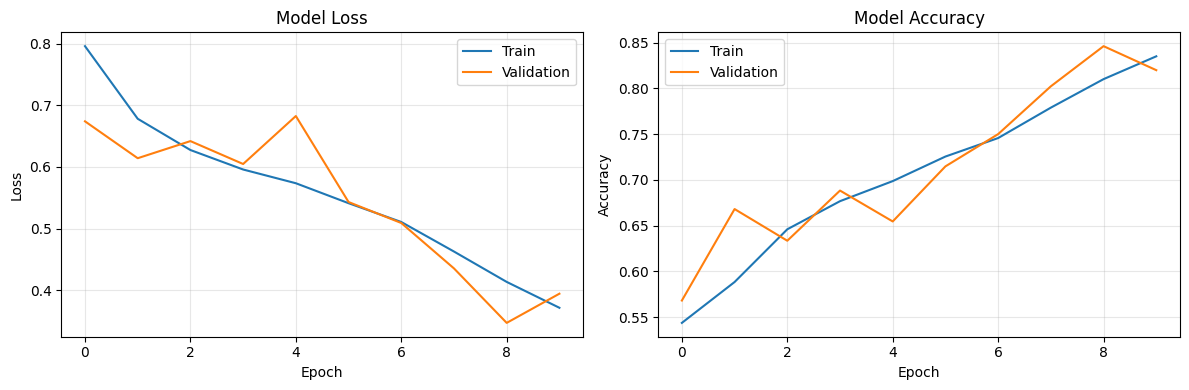


Final Results:
  Test Accuracy: 0.855
  Test AUC: 0.937
  Device Used: MPS
  Total Epochs: 10

✓ Training complete! Model ready for deployment.


In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss
axes[0].plot(history.history['loss'], label='Train')
axes[0].plot(history.history['val_loss'], label='Validation')
axes[0].set_title('Model Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history.history['accuracy'], label='Train')
axes[1].plot(history.history['val_accuracy'], label='Validation')
axes[1].set_title('Model Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Results:")
print(f"  Test Accuracy: {test_results['accuracy']:.3f}")
print(f"  Test AUC: {test_results['auc']:.3f}")
print(f"  Device Used: {DEVICE}")
print(f"  Total Epochs: {len(history.history['loss'])}")
print("\n✓ Training complete! Model ready for deployment.")
